In [5]:
## import torchtext
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torchtext.vocab import Vectors
import torchtext
from tqdm import tqdm_notebook

In [6]:
text = torchtext.data.Field(include_lengths = False)
label = torchtext.data.Field(sequential=False)
train, val, test = torchtext.datasets.SST.splits(text, label, filter_pred=lambda ex: ex.label != 'neutral')
text.build_vocab(train)
label.build_vocab(train)
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=10, device=-1, repeat = False)
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
text.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

In [9]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size):
        super(CNN, self).__init__()
        self.embeddings = nn.Embedding(text.vocab.vectors.size()[0], text.vocab.vectors.size()[1])
        self.embeddings.weight.data.copy_(text.vocab.vectors)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = in_channels, kernel_size = n) for n in (2,3,4)])
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        self.linear = nn.Linear(in_features=in_channels, out_features=out_channels, bias = True)
    
    def forward(self, x, train = True):
        embedded = self.embeddings(x)
        embedded = embedded.transpose(1, 2)
        embedded = embedded.transpose(0, 2)
        concatted_features = torch.cat([conv(embedded) for conv in self.convs if embedded.size(2) >= conv.kernel_size[0]], dim = 2)
        activated_features = nn.functional.relu(concatted_features)
        pooled = nn.functional.max_pool1d(activated_features, activated_features.size(2)).squeeze(2)
        dropped = self.dropout_train(pooled) if train else self.dropout_test(pooled)
        output = self.linear(dropped)
        logits = nn.functional.log_softmax(output, dim = 1)
        return logits

    def predict(self, x):
        logits = self.forward(x, train = False)
        return logits.max(1)[1] + 1
    
    def train(self, train_iter, val_iter, num_epochs, learning_rate = 1e-3):
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        loss_vec = []
        
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            epoch_loss = 0
            for batch in train_iter:
                x = batch.text
                y = batch.label
                
                optimizer.zero_grad()
                
                y_p = self.forward(x)
                
                loss = criterion(y_p, y-1)
                loss.backward()
                
                optimizer.step()
                epoch_loss += loss.data[0]
                
            self.model = model
            
            loss_vec.append(epoch_loss / len(train_iter))
            if epoch % 1 == 0:
                acc = self.validate(val_iter)
                print('Epoch {} loss: {} | acc: {}'.format(epoch, loss_vec[epoch-1], acc))
                self.model = model
        
        plt.plot(range(len(loss_vec)), loss_vec)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        print('\nModel trained.\n')
        self.loss_vec = loss_vec
        self.model = model

    def test(self, test_iter):
        "All models should be able to be run with following command."
        upload, trues = [], []
        # Update: for kaggle the bucket iterator needs to have batch_size 10
        for batch in test_iter:
            # Your prediction data here (don't cheat!)
            x, y = batch.text, batch.label
            probs = self.predict(x)[:len(y)]
            upload += list(probs.data)
            trues += list(y.data)
            
        correct = sum([1 if i == j else 0 for i, j in zip(upload, trues)])
        accuracy = correct / len(trues)
        print('Testset Accuracy:', accuracy)

        with open("predictions.txt", "w") as f:
            for u in upload:
                f.write(str(u) + "\n")
                
    def validate(self, val_iter):
        y_p, y_t, correct = [], [], 0
        for batch in val_iter:
            x, y = batch.text, batch.label
            probs = self.model.predict(x)[:len(y)]
            y_p += list(probs.data)
            y_t += list(y.data)
            
        correct = sum([1 if i == j else 0 for i, j in zip(y_p, y_t)])
        accuracy = correct / len(y_p)
        return accuracy

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

/Users/sob/Desktop/cs287/homework1/env/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
/Users/sob/Desktop/cs287/homework1/env/lib/python3.6/site-packages/ipykernel_launcher.py:79: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


Epoch 1 loss: 0.5709313771154495 | acc: 0.7603211009174312
Epoch 2 loss: 0.29662336955772917 | acc: 0.786697247706422
Epoch 3 loss: 0.10009956448352385 | acc: 0.7775229357798165
Epoch 4 loss: 0.03353736516747484 | acc: 0.7729357798165137
Epoch 5 loss: 0.01669091764996418 | acc: 0.7775229357798165



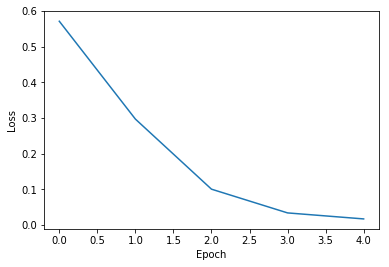


Model trained.



In [6]:
model = CNN(in_channels = 300, out_channels = 2, batch_size = 10)
model.train(train_iter = train_iter, val_iter = val_iter, num_epochs = 5, learning_rate = 1e-3)
model.test(test_iter)